In [1]:
import pandas as pd

In [3]:
referrals = pd.read_csv('../../Welcome-Centre-DataCorps-Data/referrals.csv')

/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (44,46,47,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
packs = pd.read_csv('../../Welcome-Centre-DataCorps-Data/packs.csv', index_col=0).set_index('ReferralInstanceID')
pack_count = pd.Series(packs.groupby(packs.index).size(), name='total_packs')
referrals['pack_count'] = pack_count

In [6]:
referrals['ReferralTakenDate'] = pd.to_datetime(referrals['ReferralTakenDate'])

In [192]:
def get_dependency_tags(referrals, count_lim_packs, count_lim_referrals, pack_window_days, referral_window_days):
    conditions = []
    if count_lim_packs is not None:
        rolling_pack_count = referrals.set_index('ReferralTakenDate')\
            .groupby('ClientId')['pack_count'].resample('1D', how='sum').replace(np.nan, 0)\
            .reset_index().set_index('ReferralTakenDate').groupby('ClientId')['pack_count']\
            .rolling(pack_window_days, min_periods=0).sum()
        rolling_pack_count = rolling_pack_count.reset_index().rename(columns={'pack_count': 'cumulative_pack_count'})
        conditions.append(referrals.assign(ReferralTakenDate=pd.to_datetime(referrals['ReferralTakenDate'].dt.date))\
                          .merge(rolling_pack_count, how='left')\
                          .set_index('ReferralInstanceId')['cumulative_pack_count'].fillna(0) > count_lim_packs)
            
    if count_lim_referrals is not None:
        rolling_referral_count = referrals.assign(ref_count=1).set_index('ReferralTakenDate')\
            .groupby('ClientId')['ref_count'].resample('1D', how='sum').replace(np.nan, 0)\
            .reset_index().set_index('ReferralTakenDate').groupby('ClientId')['ref_count']\
            .rolling(referral_window_days, min_periods=0).sum()
        rolling_referral_count = rolling_referral_count.reset_index()\
            .rename(columns={'ref_count': 'cumulative_referral_count'})
        conditions.append(referrals.assign(ReferralTakenDate=pd.to_datetime(referrals['ReferralTakenDate'].dt.date))\
                          .merge(rolling_referral_count, how='left')\
                          .set_index('ReferralInstanceId')['cumulative_referral_count'].fillna(0) > count_lim_referrals)
#     return conditions
    return pd.concat(conditions, axis=1).sum(axis=1) > 0
    

In [ ]:
referrals['dependent'] = get_dependency_tags(referrals, 16, 3, 84, 84)

/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/pandas/core/groupby.py:1232: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  return get_resampler_for_grouping(self, rule, *args, **kwargs)


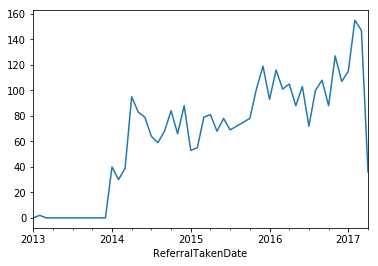

In [202]:
%matplotlib inline
referrals.set_index('ReferralTakenDate').groupby(pd.TimeGrouper('1M'))['dependent'].sum().astype(int).plot()

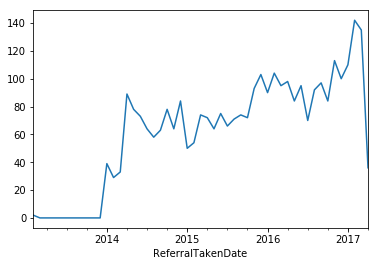

In [208]:
referrals[referrals['dependent']==True].set_index('ReferralTakenDate').groupby(pd.TimeGrouper('1M')).apply(lambda k: len(k['ClientId'].unique())).plot()